**Importing the required libraries**

In [297]:
import os
import cv2
import numpy as np
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, LeakyReLU
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score


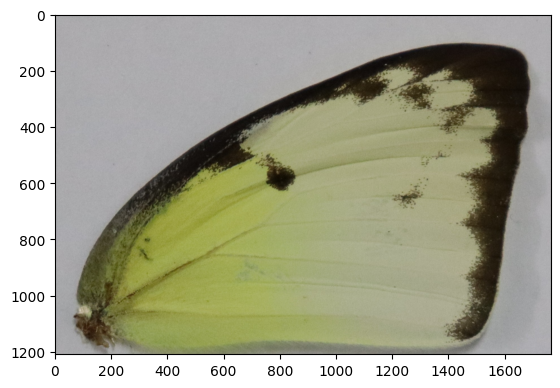

In [298]:
base_dir = os.path.join("data", "female")
file_name = "female_146.jpg"
file_path = os.path.join(base_dir, file_name)

if os.path.exists(file_path):
    img = mpimg.imread(file_path)
    imgplot = plt.imshow(img)
    plt.show()
else:
    print(f"File not found: {file_path}")

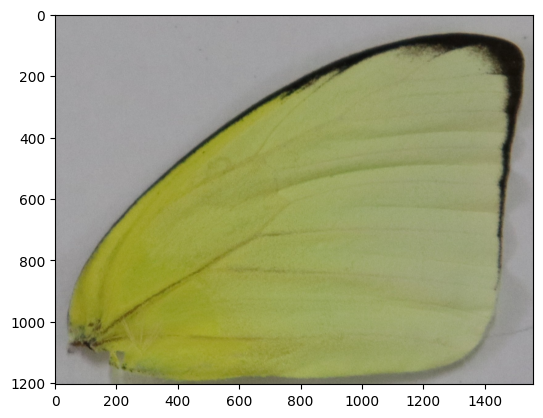

In [299]:
base_dir = os.path.join("data", "male")
file_name = "male_189.jpg"
file_path = os.path.join(base_dir, file_name)

if os.path.exists(file_path):
    img = mpimg.imread(file_path)
    imgplot = plt.imshow(img)
    plt.show()
else:
    print(f"File not found: {file_path}")

**Load and Preprocess Images**

In [300]:
# Set paths
train_dir = 'split-data/train'
val_dir = 'split-data/val'

In [301]:
# Image parameters
img_size = 256
batch_size = 8
num_classes = 1

**Data Augmentation**

In [302]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.1,
    fill_mode='nearest'
)

In [303]:
val_datagen = ImageDataGenerator(rescale=1./255)

In [304]:
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'
)

Found 320 images belonging to 2 classes.


In [305]:
val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 80 images belonging to 2 classes.


In [306]:
# Example to check a single batch
x_batch, y_batch = next(train_gen)
print(x_batch.shape, y_batch.shape)
print(y_batch)

(8, 256, 256, 3) (8,)
[1. 0. 1. 0. 1. 1. 1. 1.]


In [307]:
# Define custom F1 score metric
def f1_score_m(y_true, y_pred):
    epsilon = K.epsilon()
    y_pred = K.round(y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    precision = true_positives / (K.sum(y_pred) + epsilon)
    recall = true_positives / (K.sum(y_true) + epsilon)
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)
    return f1


# Define the AUC metric outside the function to avoid re-creating it in each call
auc_metric = tf.keras.metrics.AUC()

def auc_m(y_true, y_pred):
    return auc_metric(y_true, y_pred)

# Define custom Recall score metric

recall_metric = tf.keras.metrics.Recall()
def recall_m(y_true, y_pred):
    return recall_metric(y_true, y_pred)

**Define CNN Model**

In [308]:
# Step 1: Reset TensorFlow graph (avoids "AlreadyExistsError")
tf.keras.backend.clear_session()

# Step 2: Force garbage collection to free memory
import gc
gc.collect()

# Step 3: Reinitialize generators (to avoid duplicate references)
train_gen.reset()
val_gen.reset()


# Define the L2 regularization factor
l2_reg = 0.001

# Model Architecture
model = Sequential([
    Input(shape=(256, 256, 3)),

    Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(l2_reg), use_bias=False),
    BatchNormalization(),
    tf.keras.layers.Activation('gelu'),
    MaxPooling2D(2,2),
    layers.Dropout(0.25),

    Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(l2_reg), use_bias=False),
    BatchNormalization(),
    tf.keras.layers.Activation('gelu'),
    MaxPooling2D(2,2),
    layers.Dropout(0.3),

    Conv2D(256, (3,3), padding='same', kernel_regularizer=l2(l2_reg), use_bias=False),
    BatchNormalization(),
    tf.keras.layers.Activation('gelu'),
    MaxPooling2D(2,2),
    layers.Dropout(0.4),

    GlobalAveragePooling2D(),

    Dense(256, kernel_regularizer=l2(l2_reg), use_bias=False),
    BatchNormalization(),
    tf.keras.layers.Activation('gelu'),
    Dropout(0.5),
    Dense(128, kernel_regularizer=l2(l2_reg), use_bias=False),
    BatchNormalization(),
    tf.keras.layers.Activation('gelu'),
    Dropout(0.3),

    Dense(1, activation="sigmoid")
])

**Compile Model**

In [309]:
# Compile the model with additional metrics: AUC, Recall, and F1 Score
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', auc_m, recall_m, f1_score_m])

**Callbacks**

In [310]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint = ModelCheckpoint("cnn.h5", monitor='val_loss', save_best_only=True, verbose=1)

**Train the Model**

In [311]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=35,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

d:\Dissertation-Project\Projects\code\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7025 - auc_m: 0.6829 - f1_score_m: 3.8608 - loss: 1.2336 - recall_m: 0.7170
Epoch 1: val_loss improved from inf to 1.37692, saving model to cnn.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.7051 - auc_m: 0.6856 - f1_score_m: 3.8632 - loss: 1.2307 - recall_m: 0.7186 - val_accuracy: 0.5000 - val_auc_m: 0.8777 - val_f1_score_m: 0.0000e+00 - val_loss: 1.3769 - val_recall_m: 0.7901 - learning_rate: 0.0010
Epoch 2/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8320 - auc_m: 0.8625 - f1_score_m: 3.6827 - loss: 1.0180 - recall_m: 0.7018
Epoch 2: val_loss improved from 1.37692 to 1.32405, saving model to cnn.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.8326 - auc_m: 0.8627 - f1_score_m: 3.6870 - loss: 1.0170 - recall_m: 0.7022 - val_accuracy: 0.6500 - val_auc_m: 0.8854 - val_f1_score_m: 2.7432 - val_loss: 1.3240 - val_recall_m: 0.7463 - learning_rate: 0.0010
Epoch 3/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8577 - auc_m: 0.8863 - f1_score_m: 3.6774 - loss: 0.9696 - recall_m: 0.7459
Epoch 3: val_loss improved from 1.32405 to 1.30413, saving model to cnn.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.8579 - auc_m: 0.8864 - f1_score_m: 3.6801 - loss: 0.9694 - recall_m: 0.7461 - val_accuracy: 0.5875 - val_auc_m: 0.8973 - val_f1_score_m: 1.2283 - val_loss: 1.3041 - val_recall_m: 0.7547 - learning_rate: 0.0010
Epoch 4/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9080 - auc_m: 0.8959 - f1_score_m: 3.9539 - loss: 0.8897 - recall_m: 0.7420
Epoch 4: val_loss improved from 1.30413 to 1.29205, saving model to cnn.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9079 - auc_m: 0.8960 - f1_score_m: 3.9545 - loss: 0.8893 - recall_m: 0.7422 - val_accuracy: 0.5000 - val_auc_m: 0.9073 - val_f1_score_m: 0.0000e+00 - val_loss: 1.2920 - val_recall_m: 0.7567 - learning_rate: 0.0010
Epoch 5/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9195 - auc_m: 0.9066 - f1_score_m: 3.9192 - loss: 0.7963 - recall_m: 0.7378
Epoch 5: val_loss did not improve from 1.29205
40/40 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9195 - auc_m: 0.9067 - f1_score_m: 3.9194 - loss: 0.7963 - recall_m: 0.7380 - val_accuracy: 0.5000 - val_auc_m: 0.9164 - val_f1_score_m: 0.0000e+00 - val_loss: 1.3482 - val_recall_m: 0.7522 - learning_rate: 0.0010
Epoch 6/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9246 - auc_m: 0.9130 - f1_score_m: 4.0406 - loss: 0.7884 - recall_m: 0.7382
Epoch 6: val_loss did not improve from 1.29205
40/40 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9245 - auc_m: 0.9131 - f1_score_m: 4.0363

40/40 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.8854 - auc_m: 0.9163 - f1_score_m: 3.8564 - loss: 0.8153 - recall_m: 0.7345 - val_accuracy: 0.6875 - val_auc_m: 0.9182 - val_f1_score_m: 4.0000 - val_loss: 1.1160 - val_recall_m: 0.7507 - learning_rate: 0.0010
Epoch 8/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9726 - auc_m: 0.9213 - f1_score_m: 4.0886 - loss: 0.6387 - recall_m: 0.7620
Epoch 8: val_loss did not improve from 1.11600
40/40 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9722 - auc_m: 0.9214 - f1_score_m: 4.0844 - loss: 0.6393 - recall_m: 0.7621 - val_accuracy: 0.5625 - val_auc_m: 0.9241 - val_f1_score_m: 4.0000 - val_loss: 1.1578 - val_recall_m: 0.7767 - learning_rate: 0.0010
Epoch 9/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9109 - auc_m: 0.9253 - f1_score_m: 3.7902 - loss: 0.7203 - recall_m: 0.7835
Epoch 9: val_loss improved from 1.11600 to 1.01685, saving model to cnn.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9115 - auc_m: 0.9253 - f1_score_m: 3.7937 - loss: 0.7187 - recall_m: 0.7836 - val_accuracy: 0.6875 - val_auc_m: 0.9288 - val_f1_score_m: 4.0000 - val_loss: 1.0168 - val_recall_m: 0.7957 - learning_rate: 0.0010
Epoch 10/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9497 - auc_m: 0.9308 - f1_score_m: 3.9462 - loss: 0.6112 - recall_m: 0.8024
Epoch 10: val_loss improved from 1.01685 to 0.89895, saving model to cnn.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9494 - auc_m: 0.9309 - f1_score_m: 3.9487 - loss: 0.6115 - recall_m: 0.8025 - val_accuracy: 0.7875 - val_auc_m: 0.9352 - val_f1_score_m: 2.8190 - val_loss: 0.8989 - val_recall_m: 0.8103 - learning_rate: 0.0010
Epoch 11/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9189 - auc_m: 0.9350 - f1_score_m: 3.7891 - loss: 0.6828 - recall_m: 0.8095
Epoch 11: val_loss improved from 0.89895 to 0.86585, saving model to cnn.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.9194 - auc_m: 0.9351 - f1_score_m: 3.7911 - loss: 0.6815 - recall_m: 0.8095 - val_accuracy: 0.9000 - val_auc_m: 0.9376 - val_f1_score_m: 4.0000 - val_loss: 0.8658 - val_recall_m: 0.8168 - learning_rate: 0.0010
Epoch 12/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9298 - auc_m: 0.9388 - f1_score_m: 3.7309 - loss: 0.5773 - recall_m: 0.8204
Epoch 12: val_loss did not improve from 0.86585
40/40 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.9296 - auc_m: 0.9388 - f1_score_m: 3.7339 - loss: 0.5775 - recall_m: 0.8205 - val_accuracy: 0.7125 - val_auc_m: 0.9414 - val_f1_score_m: 2.2619 - val_loss: 0.8926 - val_recall_m: 0.8225 - learning_rate: 0.0010
Epoch 13/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9523 - auc_m: 0.9415 - f1_score_m: 3.9592 - loss: 0.5391 - recall_m: 0.8203
Epoch 13: val_loss improved from 0.86585 to 0.65998, saving model to cnn.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9520 - auc_m: 0.9415 - f1_score_m: 3.9589 - loss: 0.5391 - recall_m: 0.8203 - val_accuracy: 0.9500 - val_auc_m: 0.9441 - val_f1_score_m: 4.0000 - val_loss: 0.6600 - val_recall_m: 0.8262 - learning_rate: 0.0010
Epoch 14/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9430 - auc_m: 0.9455 - f1_score_m: 3.8602 - loss: 0.5119 - recall_m: 0.8301
Epoch 14: val_loss did not improve from 0.65998
40/40 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.9428 - auc_m: 0.9455 - f1_score_m: 3.8619 - loss: 0.5121 - recall_m: 0.8301 - val_accuracy: 0.6000 - val_auc_m: 0.9471 - val_f1_score_m: 1.3253 - val_loss: 1.3252 - val_recall_m: 0.8315 - learning_rate: 0.0010
Epoch 15/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8973 - auc_m: 0.9450 - f1_score_m: 3.7633 - loss: 0.5627 - recall_m: 0.8268
Epoch 15: val_loss did not improve from 0.65998
40/40 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.8978 - auc_m: 0.9450 - f1_score_m: 3.7658 - l

40/40 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9646 - auc_m: 0.9416 - f1_score_m: 4.1197 - loss: 0.4320 - recall_m: 0.8210 - val_accuracy: 0.9625 - val_auc_m: 0.9438 - val_f1_score_m: 4.0000 - val_loss: 0.4666 - val_recall_m: 0.8262 - learning_rate: 5.0000e-04
Epoch 18/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9104 - auc_m: 0.9446 - f1_score_m: 3.7321 - loss: 0.5472 - recall_m: 0.8286
Epoch 18: val_loss did not improve from 0.46658
40/40 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.9102 - auc_m: 0.9446 - f1_score_m: 3.7348 - loss: 0.5470 - recall_m: 0.8286 - val_accuracy: 0.5875 - val_auc_m: 0.9451 - val_f1_score_m: 1.1378 - val_loss: 1.4781 - val_recall_m: 0.8281 - learning_rate: 5.0000e-04
Epoch 19/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8205 - auc_m: 0.9424 - f1_score_m: 3.7983 - loss: 0.7578 - recall_m: 0.8233
Epoch 19: val_loss did not improve from 0.46658
40/40 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.8221 - auc_m: 0.9424 - f1_score_m: 3.

40/40 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9629 - auc_m: 0.9465 - f1_score_m: 4.0728 - loss: 0.4361 - recall_m: 0.8329 - val_accuracy: 0.9375 - val_auc_m: 0.9486 - val_f1_score_m: 4.0000 - val_loss: 0.4484 - val_recall_m: 0.8375 - learning_rate: 2.5000e-04
Epoch 22/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9720 - auc_m: 0.9497 - f1_score_m: 3.9137 - loss: 0.4037 - recall_m: 0.8401
Epoch 22: val_loss improved from 0.44836 to 0.40571, saving model to cnn.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.9718 - auc_m: 0.9497 - f1_score_m: 3.9142 - loss: 0.4057 - recall_m: 0.8401 - val_accuracy: 0.9875 - val_auc_m: 0.9509 - val_f1_score_m: 4.0000 - val_loss: 0.4057 - val_recall_m: 0.8435 - learning_rate: 2.5000e-04
Epoch 23/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9511 - auc_m: 0.9517 - f1_score_m: 4.1061 - loss: 0.4003 - recall_m: 0.8456
Epoch 23: val_loss did not improve from 0.40571
40/40 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.9513 - auc_m: 0.9517 - f1_score_m: 4.1038 - loss: 0.4000 - recall_m: 0.8457 - val_accuracy: 0.9250 - val_auc_m: 0.9530 - val_f1_score_m: 4.0000 - val_loss: 0.5104 - val_recall_m: 0.8493 - learning_rate: 2.5000e-04
Epoch 24/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9546 - auc_m: 0.9536 - f1_score_m: 3.9873 - loss: 0.4583 - recall_m: 0.8510
Epoch 24: val_loss did not improve from 0.40571
40/40 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9547 - auc_m: 0.9536 - f1_score_m: 3.

40/40 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.9474 - auc_m: 0.9550 - f1_score_m: 4.1422 - loss: 0.3791 - recall_m: 0.8527 - val_accuracy: 0.9875 - val_auc_m: 0.9562 - val_f1_score_m: 4.0000 - val_loss: 0.4011 - val_recall_m: 0.8554 - learning_rate: 1.2500e-04
Epoch 27/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9387 - auc_m: 0.9565 - f1_score_m: 3.9950 - loss: 0.5066 - recall_m: 0.8567
Epoch 27: val_loss did not improve from 0.40107
40/40 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9386 - auc_m: 0.9565 - f1_score_m: 3.9928 - loss: 0.5061 - recall_m: 0.8567 - val_accuracy: 0.8000 - val_auc_m: 0.9571 - val_f1_score_m: 2.9354 - val_loss: 0.6630 - val_recall_m: 0.8577 - learning_rate: 1.2500e-04
Epoch 28/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9741 - auc_m: 0.9572 - f1_score_m: 3.8599 - loss: 0.3712 - recall_m: 0.8574
Epoch 28: val_loss improved from 0.40107 to 0.37967, saving model to cnn.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.9742 - auc_m: 0.9572 - f1_score_m: 3.8627 - loss: 0.3712 - recall_m: 0.8574 - val_accuracy: 0.9875 - val_auc_m: 0.9584 - val_f1_score_m: 4.0000 - val_loss: 0.3797 - val_recall_m: 0.8602 - learning_rate: 1.2500e-04
Epoch 29/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9452 - auc_m: 0.9588 - f1_score_m: 4.0399 - loss: 0.4410 - recall_m: 0.8617
Epoch 29: val_loss did not improve from 0.37967
40/40 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9452 - auc_m: 0.9588 - f1_score_m: 4.0379 - loss: 0.4417 - recall_m: 0.8617 - val_accuracy: 0.6250 - val_auc_m: 0.9589 - val_f1_score_m: 1.5495 - val_loss: 1.1816 - val_recall_m: 0.8624 - learning_rate: 1.2500e-04
Epoch 30/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9675 - auc_m: 0.9583 - f1_score_m: 3.9643 - loss: 0.3495 - recall_m: 0.8602
Epoch 30: val_loss improved from 0.37967 to 0.36711, saving model to cnn.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.9678 - auc_m: 0.9583 - f1_score_m: 3.9646 - loss: 0.3494 - recall_m: 0.8602 - val_accuracy: 0.9875 - val_auc_m: 0.9595 - val_f1_score_m: 4.0000 - val_loss: 0.3671 - val_recall_m: 0.8629 - learning_rate: 1.2500e-04
Epoch 31/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9710 - auc_m: 0.9600 - f1_score_m: 4.4762 - loss: 0.3679 - recall_m: 0.8644
Epoch 31: val_loss did not improve from 0.36711
40/40 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.9709 - auc_m: 0.9600 - f1_score_m: 4.4635 - loss: 0.3683 - recall_m: 0.8644 - val_accuracy: 0.9000 - val_auc_m: 0.9608 - val_f1_score_m: 3.5733 - val_loss: 0.4303 - val_recall_m: 0.8659 - learning_rate: 1.2500e-04
Epoch 32/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8958 - auc_m: 0.9609 - f1_score_m: 3.9293 - loss: 0.4820 - recall_m: 0.8659
Epoch 32: val_loss did not improve from 0.36711
40/40 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.8963 - auc_m: 0.9609 - f1_score_m: 3.

40/40 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9223 - auc_m: 0.9619 - f1_score_m: 3.8995 - loss: 0.3874 - recall_m: 0.8679 - val_accuracy: 0.9750 - val_auc_m: 0.9627 - val_f1_score_m: 4.0000 - val_loss: 0.3615 - val_recall_m: 0.8701 - learning_rate: 1.2500e-04
Epoch 34/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9625 - auc_m: 0.9631 - f1_score_m: 3.9545 - loss: 0.4193 - recall_m: 0.8711
Epoch 34: val_loss improved from 0.36148 to 0.35287, saving model to cnn.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9628 - auc_m: 0.9631 - f1_score_m: 3.9548 - loss: 0.4182 - recall_m: 0.8711 - val_accuracy: 0.9875 - val_auc_m: 0.9638 - val_f1_score_m: 4.0000 - val_loss: 0.3529 - val_recall_m: 0.8732 - learning_rate: 1.2500e-04
Epoch 35/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9626 - auc_m: 0.9642 - f1_score_m: 4.0069 - loss: 0.3636 - recall_m: 0.8743
Epoch 35: val_loss did not improve from 0.35287
40/40 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9623 - auc_m: 0.9642 - f1_score_m: 4.0056 - loss: 0.3648 - recall_m: 0.8743 - val_accuracy: 0.9875 - val_auc_m: 0.9646 - val_f1_score_m: 4.0000 - val_loss: 0.3578 - val_recall_m: 0.8756 - learning_rate: 1.2500e-04
Restoring model weights from the end of the best epoch: 34.


In [312]:
# Predict on validation data
y_probs = model.predict(X_val)
y_preds = (y_probs >= 0.5).astype(int)

# Print shapes to verify dimensions
print(f"\nShape of y_probs: {y_probs.shape}")
print(f"Shape of y_preds: {y_preds.shape}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step

Shape of y_probs: (80, 1)
Shape of y_preds: (80, 1)


**Results**

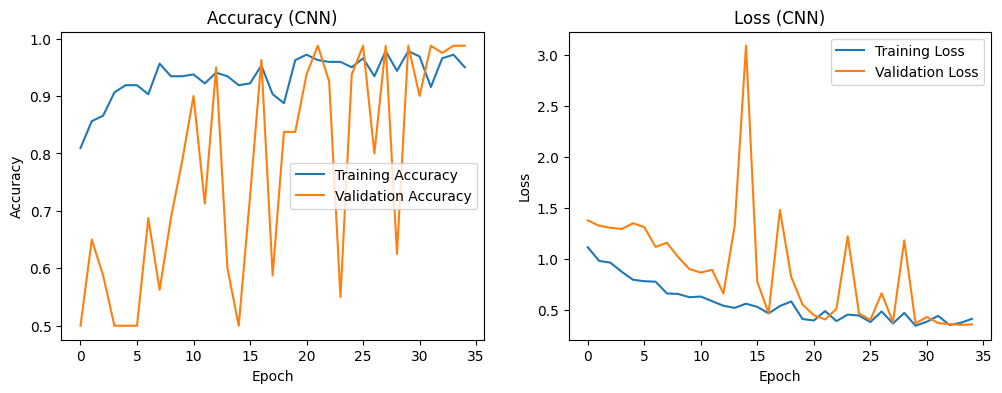

In [313]:
import matplotlib.pyplot as plt

# Ploting training & validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy (CNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Ploting training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss (CNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
Classification Report:

              precision    recall  f1-score   support

      female       1.00      0.97      0.99        40
        male       0.98      1.00      0.99        40

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



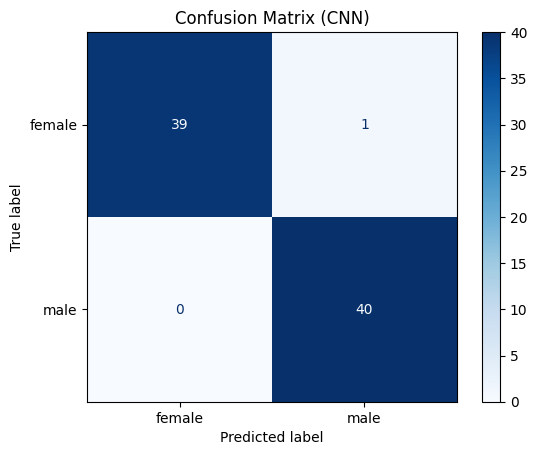

In [314]:
# Predict on validation data
Y_pred_probs = model.predict(X_val_scaled)
Y_pred = (Y_pred_probs > 0.5).astype("int32").flatten()

# Classification Report
print("Classification Report:\n")
print(classification_report(Y_val, Y_pred, target_names=['female', 'male']))

# Confusion Matrix
cm = confusion_matrix(Y_val, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['female', 'male'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (CNN)')
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step


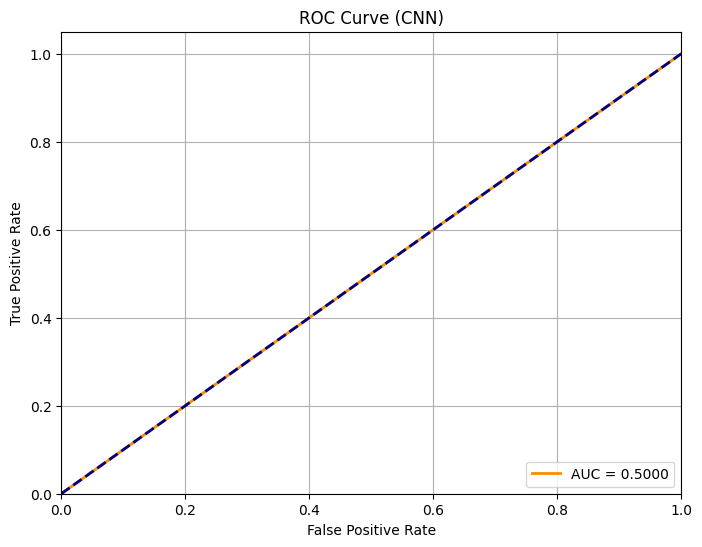

AUC-ROC Score for CNN: 0.5000


In [319]:
# Predict probabilities for the validation data
y_pred_probs_cnn = model.predict(X_val)

# Compute ROC curve and AUC for CNN model
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(Y_val, y_pred_probs_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

# Plotting the ROC curve for CNN
plt.figure(figsize=(8, 6))
plt.plot(fpr_cnn, tpr_cnn, color='darkorange', lw=2, label=f'AUC = {roc_auc_cnn:.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (CNN)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# AUC-ROC Score
print(f"AUC-ROC Score for CNN: {roc_auc_cnn:.4f}")

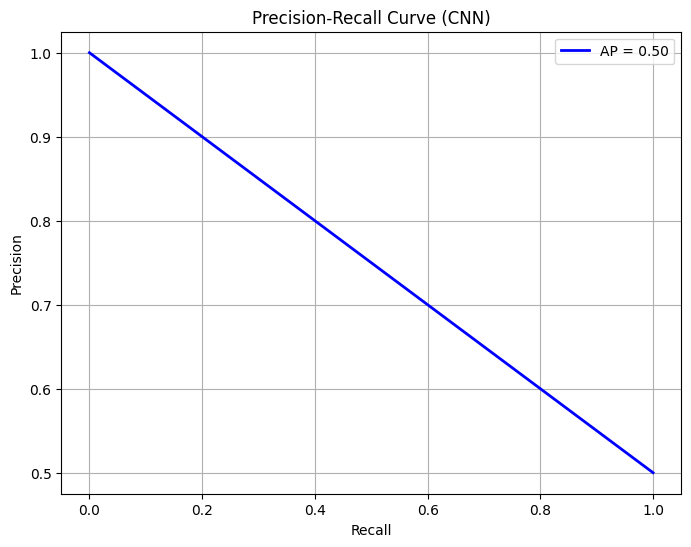

Average Precision (AP) Score for CNN: 0.50


In [320]:
# Compute precision-recall pairs and average precision for CNN model
precision_cnn, recall_cnn, thresholds_cnn = precision_recall_curve(Y_val, y_pred_probs_cnn)
ap_score_cnn = average_precision_score(Y_val, y_pred_probs_cnn)

# Plot Precision-Recall Curve for CNN
plt.figure(figsize=(8, 6))
plt.plot(recall_cnn, precision_cnn, color='b', linewidth=2, label=f'AP = {ap_score_cnn:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (CNN)')
plt.grid(True)
plt.legend()
plt.show()

# Average Precision (AP) Score
print(f"Average Precision (AP) Score for CNN: {ap_score_cnn:.2f}")

In [318]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 128)  │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 1,413,061 (5.39 MB)

 Trainable params: 470,465 (1.79 MB)

 Non-trainable params: 1,664 (6.50 KB)

 Optimizer params: 940,932 (3.59 MB)